In [3]:
import pandas as pd
import numpy as np
import cPickle as pickle
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interp
from itertools import cycle

from sklearn import metrics
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, average_precision_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import label_propagation
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

def cross_val_roc(classifier, X, y, n_splits=3, balance=False, test_size=0.25):
    # Run classifier with cross-validation and plot ROC curves
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2
    plt.clf()
    plt.figure(figsize=(8,6));
    
    if balance:
        splits = StratifiedShuffleSplit(y, n_splits, test_size=test_size)
    else:
        splits = StratifiedKFold(n_splits=n_splits).split(X, y)
    
    i = 0
    for (train, test), color in zip(splits, colors):
        X_train, X_test = X.ix[train], X.ix[test]
        y_train, y_test = y.ix[train], y.ix[test]
        if balance:
            X_train, y_train = balance_train_index(X_train, y_train)
        
        probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show();

def cv_score(clf, X, y, cv=5, scoring='f1'):
    print scoring + ' cross validation score: ' + str(np.mean(cross_val_score(rf, X, y, cv=cv, scoring=scoring)))
    
def combine_and_balance_dfs(df1, df2, minority_fraction=0.5, ignore_index=True):
    if df1.shape[0] > df2.shape[0]:
        df1, df2 = df2, df1
    m = int(df1.shape[0]*(1.0/minority_fraction - 1))
    if m > df2.shape[0]:
        print 'majority df too small to achieve desired minority fraction'
        m = df2.shape[0]
    return df1.append(df2.sample(m), ignore_index=ignore_index)

def balance_train_index(X_train, y_train):
    pos_index = y_train[y_train == 1].index
    neg_index = y_train[y_train == 0].index
    reduced_neg_index = np.random.choice(neg_index, pos_index.shape[0], replace=False)
    b_index = pos_index.tolist() + reduced_neg_index.tolist()
    return X_train.ix[b_index], y_train.ix[b_index]

#Balances training split but not testing split
def balanced_train_test_split(X, y, test_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, y_train = balance_train_index(X_train, y_train)
    return X_train, X_test, y_train, y_test

def plot_multiple_precision_recall_curves(y_true, y_pred_probas, baseline=0):
    plt.clf();
    n_rows = len(y_true)/2 if len(y_true) % 2 == 0 else len(y_true)/2 + 1
    fig, axes = plt.subplots(n_rows, 2, figsize=(20,20))
    for ax, tup in zip(axes.flatten(), zip(y_true, y_pred_probas)):
        yt, yp = tup   
        precision, recall, _ = precision_recall_curve(yt, yp)
        avg_precision = average_precision_score(yt, yp)
        ax.plot(recall, precision, color='navy', label='Precision-Recall curve');
        ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title('Precision-Recall example: AUC={0:0.2f}'.format(avg_precision))
        ax.legend(loc="lower left")
    plt.show();

def plot_precision_recall_curve(y_true, y_pred_probas, baseline=0):
    plt.clf();
    plt.figure(figsize=(8,6));
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probas)
    avg_precision = average_precision_score(y_true, y_pred_probas)
    plt.plot(recall, precision, color='navy', label='Precision-Recall curve');
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(avg_precision))
    plt.legend(loc="lower left")
    plt.show();

/Users/Jake1/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
non_allergen_fp = 'pickles/ah_non_allergen_df_with_features.pkl'
allergen_fp = 'pickles/ah_allergen_df_with_features.pkl'

with open(non_allergen_fp, 'r') as fin:
    non_allergen_df = pickle.load(fin)
with open(allergen_fp, 'r') as fin:
    allergen_df = pickle.load(fin)

df = allergen_df.append(non_allergen_df, ignore_index=True)
balanced_df = combine_and_balance_dfs(allergen_df, non_allergen_df, minority_fraction=0.5)

In [1]:
# def test_plot(x, y, ax):
#     ax.plot(x, y)
#     ax.set_xlabel('yup')

# def multi(x, y):
#     plt.clf();
#     n_rows = len(x)/2 if len(x) % 2 == 0 else len(x)/2 + 1
#     fig, axes = plt.subplots(n_rows, 2, figsize=(20,20))
#     for ax, tup in zip(axes.flatten(), zip(x, y)):
#         test_plot(tup[0], tup[1], ax)
#     plt.show()
#     plt.
    
# x = [[1,2],[3,4], [9,10]]*2
# y = [[5,6], [7,8], [11,12]]*2
# multi(x,y)

In [5]:
percents = [0.003, 0.004, 0.006, 0.008, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
percent_dfs = []
for p in percents:
    percent_dfs.append(combine_and_balance_dfs(allergen_df, non_allergen_df, minority_fraction=p))

majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction


In [6]:
sdf = df.sample(11000).reset_index(drop=True)

In [7]:
def df_ratio(df):
    return df[df['allergen'] == 1].shape[0]*1.0/df.shape[0]

    
print df_ratio(df)
print df_ratio(sdf)
for percent_df in percent_dfs:
    print df_ratio(percent_df)

0.105411103303
0.105545454545
0.105411103303
0.105411103303
0.105411103303
0.105411103303
0.105411103303
0.105411103303
0.105411103303
0.2
0.3
0.4
0.5


In [65]:
print percent_dfs[0].shape, df.shape

(11384, 30) (11384, 30)


## balanced versus unbalanced training

In [12]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
nb = Pipeline([('vect', TfidfVectorizer(analyzer='char', ngram_range=(1,4))), ('nb', MultinomialNB())])

def evaluate_models(tests, classifiers, balance=False):
    for X, y, m in tests:
        for bal in list(balance):
            for clf in classifiers:
                print '\n\n', m
                print 'balanced training data: ', str(bal)
                print str(clf).split('(')[0]
                if bal:
                    X_train, X_test, y_train, y_test = balanced_train_test_split(X, y, test_size=.25)
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_pred_proba = clf.predict_proba(X_test)
                print 'f1 score: ', f1_score(y_test, y_pred)
                plot_precision_recall_curve(y_test, y_pred_proba[:, 1], baseline=m[0])
                cross_val_roc(clf, X, y)
                print '\n\n'
                print y_pred_proba[0:10]



(0.5, 'balanced df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.769771528998


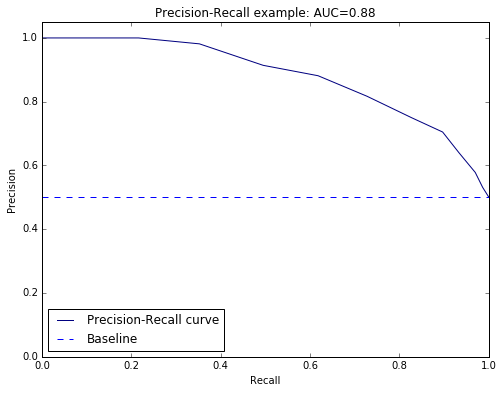

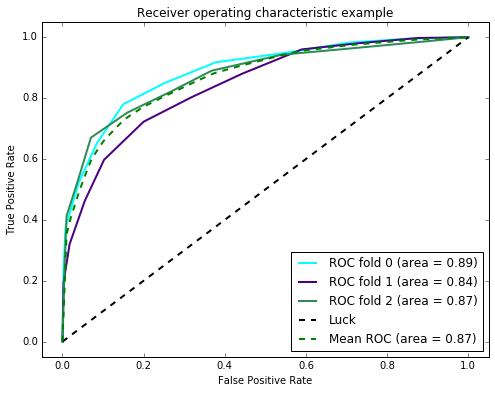




[[ 0.3  0.7]
 [ 1.   0. ]
 [ 0.9  0.1]
 [ 0.6  0.4]
 [ 0.9  0.1]
 [ 0.3  0.7]
 [ 0.   1. ]
 [ 0.1  0.9]
 [ 0.   1. ]
 [ 0.2  0.8]]


(0.5, 'balanced df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.751547303271


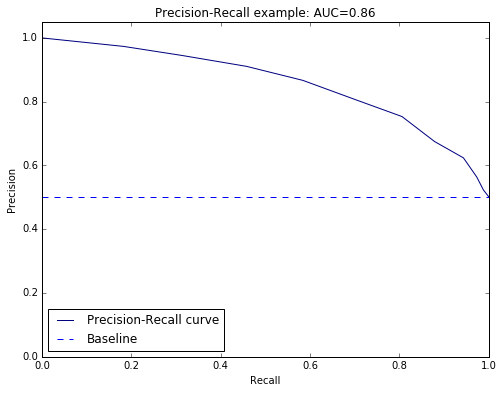

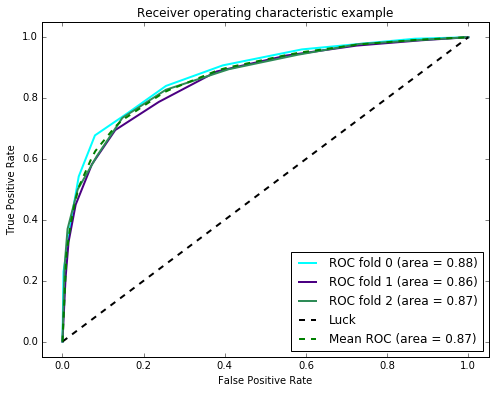




[[ 0.9  0.1]
 [ 0.6  0.4]
 [ 0.6  0.4]
 [ 0.5  0.5]
 [ 0.1  0.9]
 [ 0.4  0.6]
 [ 0.9  0.1]
 [ 0.9  0.1]
 [ 0.8  0.2]
 [ 0.6  0.4]]


('0.105411103303', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.475982532751


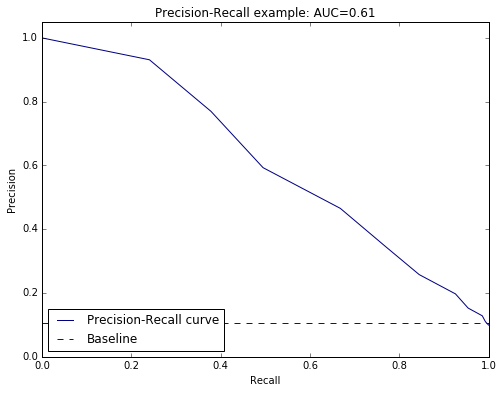

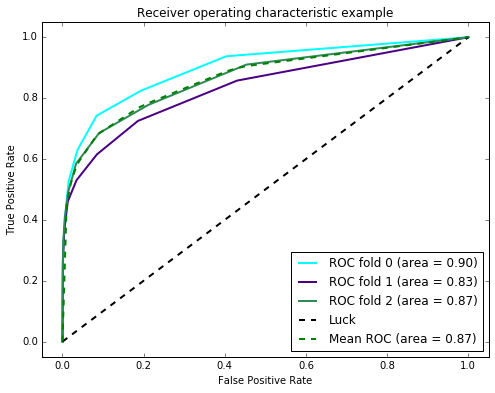




[[ 0.7  0.3]
 [ 1.   0. ]
 [ 0.6  0.4]
 [ 0.6  0.4]
 [ 0.7  0.3]
 [ 0.6  0.4]
 [ 0.9  0.1]
 [ 1.   0. ]
 [ 0.8  0.2]
 [ 0.4  0.6]]


('0.105411103303', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.503546099291


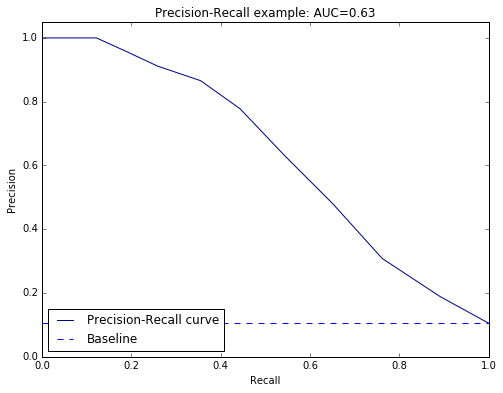

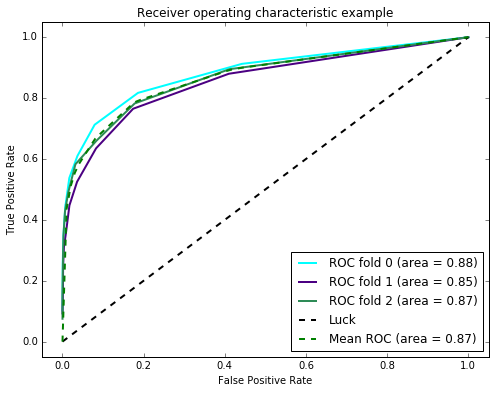




[[ 0.9  0.1]
 [ 1.   0. ]
 [ 0.9  0.1]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 0.8  0.2]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 0.9  0.1]
 [ 0.8  0.2]]


('0.105411103303', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.467692307692


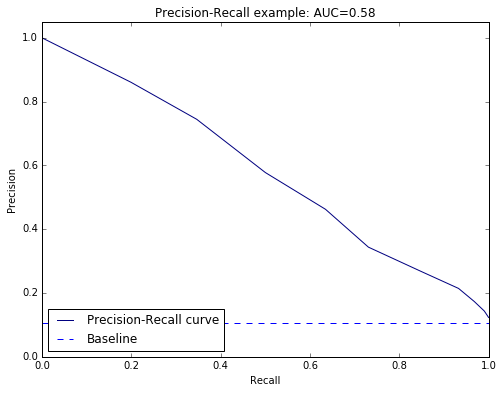

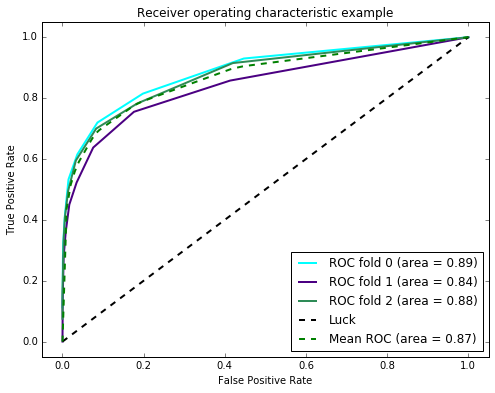




[[ 0.8  0.2]
 [ 0.6  0.4]
 [ 0.   1. ]
 [ 0.1  0.9]
 [ 0.9  0.1]
 [ 1.   0. ]
 [ 0.1  0.9]
 [ 0.7  0.3]
 [ 0.4  0.6]
 [ 1.   0. ]]


('0.105411103303', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.500613496933


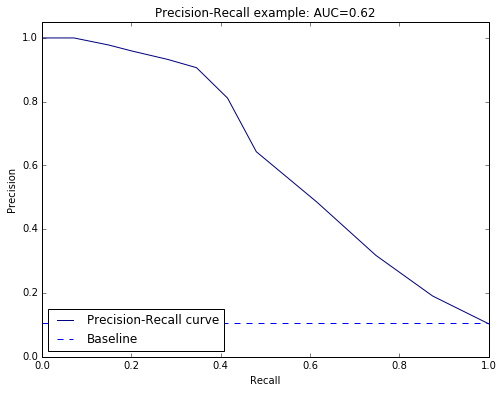

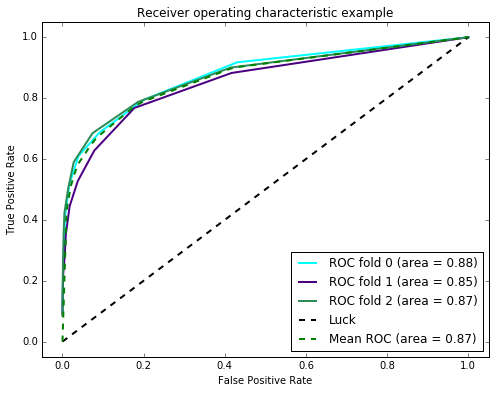




[[ 1.   0. ]
 [ 0.9  0.1]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 0.9  0.1]
 [ 0.8  0.2]
 [ 0.9  0.1]]


('0.105411103303', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.465725806452


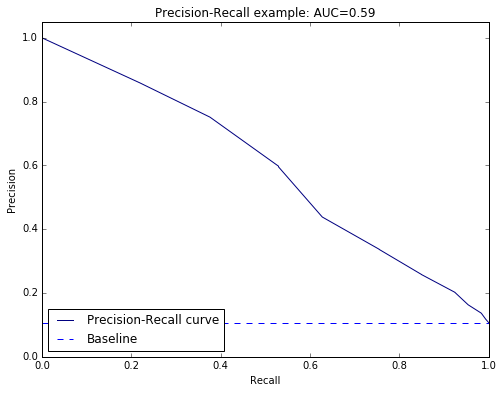

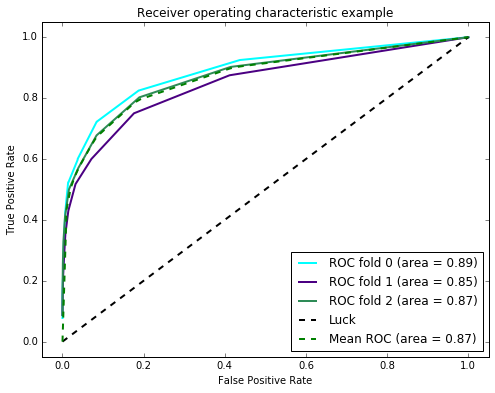




[[ 0.5    0.5  ]
 [ 0.9    0.1  ]
 [ 0.2    0.8  ]
 [ 0.625  0.375]
 [ 0.8    0.2  ]
 [ 0.     1.   ]
 [ 0.9    0.1  ]
 [ 0.6    0.4  ]
 [ 0.9    0.1  ]
 [ 0.2    0.8  ]]


('0.105411103303', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.463182897862


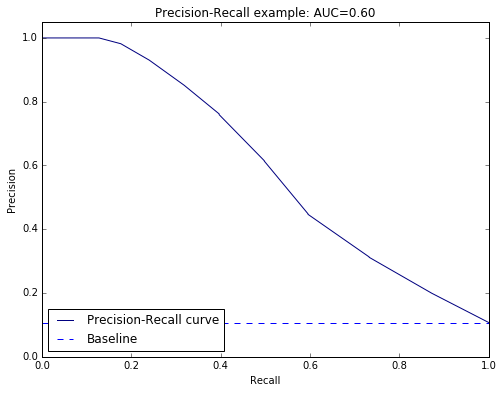

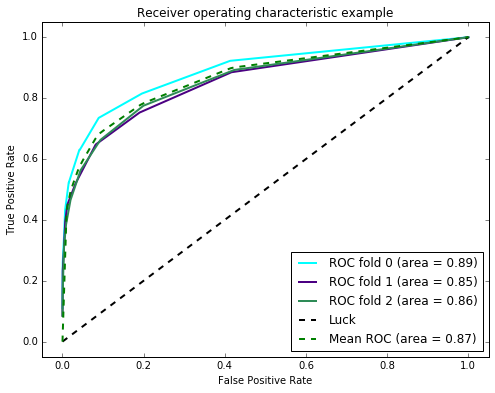




[[ 0.7  0.3]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 0.7  0.3]
 [ 0.8  0.2]
 [ 0.9  0.1]
 [ 0.7  0.3]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 0.9  0.1]]


('0.2', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.611920529801


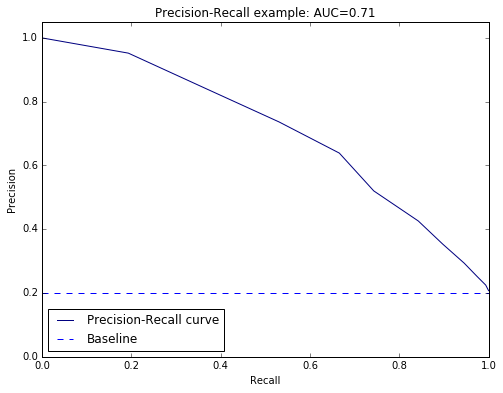

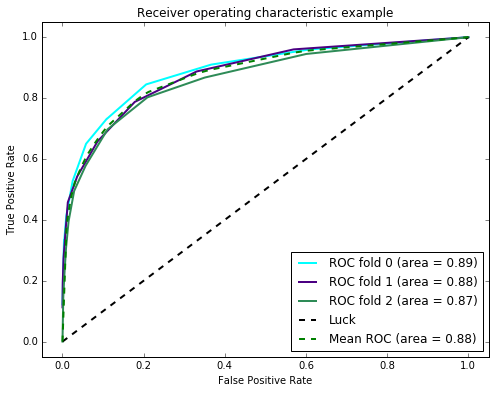




[[ 0.1  0.9]
 [ 0.9  0.1]
 [ 0.   1. ]
 [ 0.9  0.1]
 [ 0.6  0.4]
 [ 0.8  0.2]
 [ 0.1  0.9]
 [ 1.   0. ]
 [ 0.1  0.9]
 [ 0.9  0.1]]


('0.2', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.578260869565


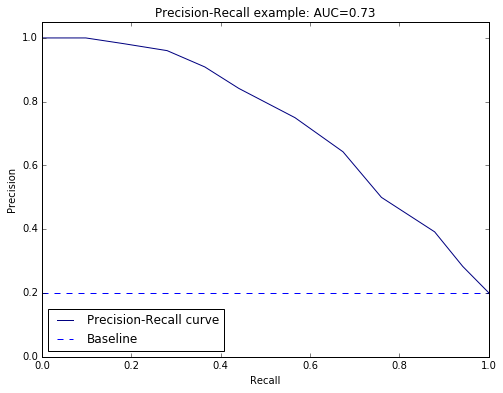

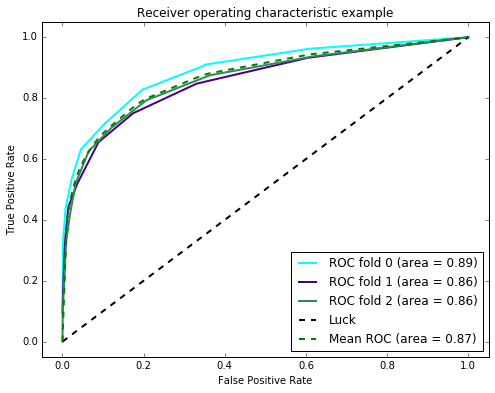




[[ 0.7  0.3]
 [ 1.   0. ]
 [ 0.9  0.1]
 [ 0.2  0.8]
 [ 0.8  0.2]
 [ 0.6  0.4]
 [ 1.   0. ]
 [ 0.9  0.1]
 [ 0.9  0.1]
 [ 0.9  0.1]]


('0.3', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.693572496263


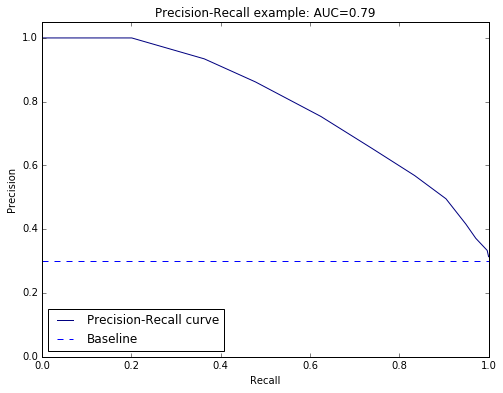

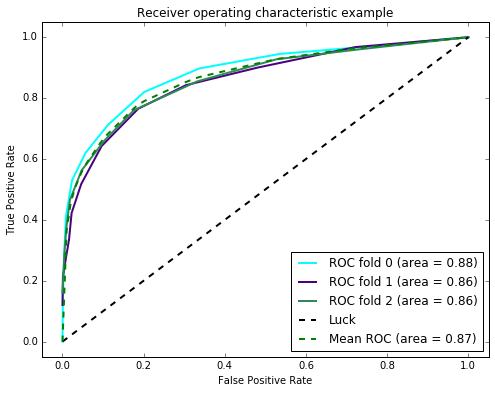




[[ 0.5  0.5]
 [ 0.8  0.2]
 [ 0.8  0.2]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.1  0.9]
 [ 0.   1. ]
 [ 0.4  0.6]]


('0.3', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.64979757085


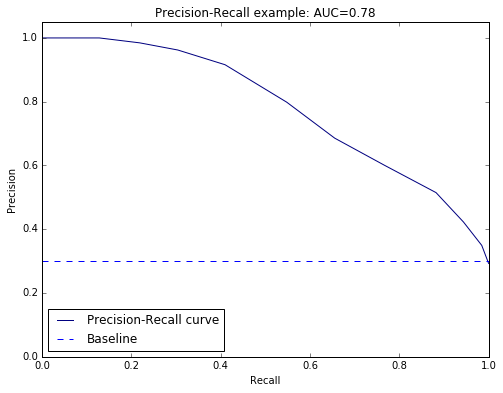

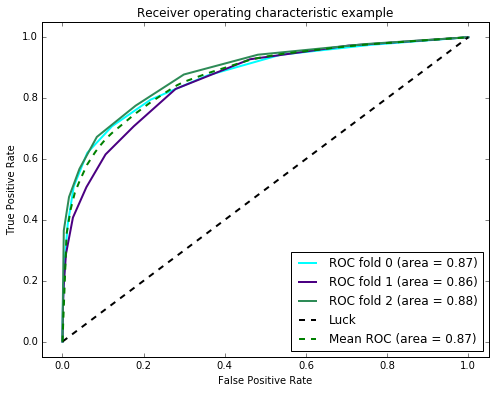




[[ 0.8  0.2]
 [ 0.   1. ]
 [ 0.9  0.1]
 [ 0.7  0.3]
 [ 0.4  0.6]
 [ 0.7  0.3]
 [ 1.   0. ]
 [ 0.1  0.9]
 [ 0.6  0.4]
 [ 0.6  0.4]]


('0.4', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.752025931929


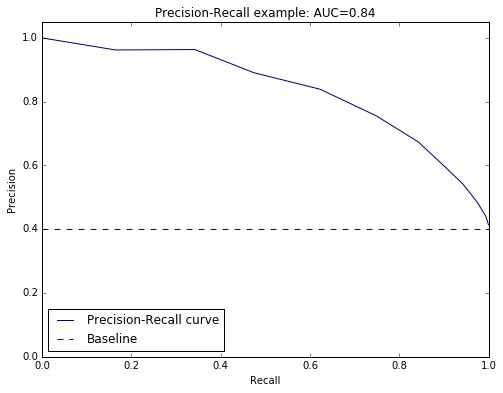

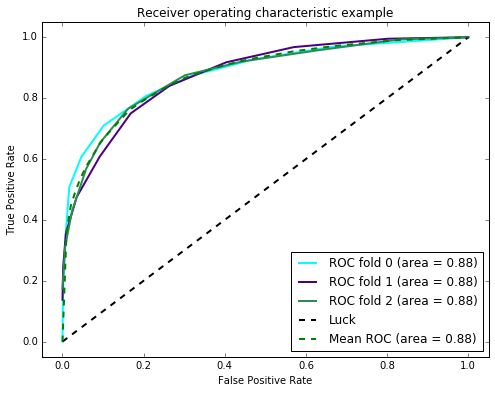




[[ 0.7  0.3]
 [ 0.4  0.6]
 [ 0.8  0.2]
 [ 0.9  0.1]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.3  0.7]
 [ 0.   1. ]
 [ 0.2  0.8]
 [ 1.   0. ]]


('0.4', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.713107241063


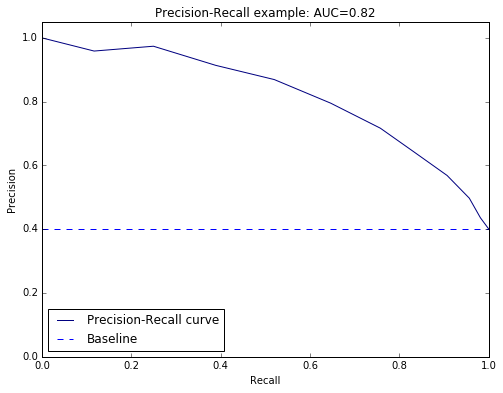

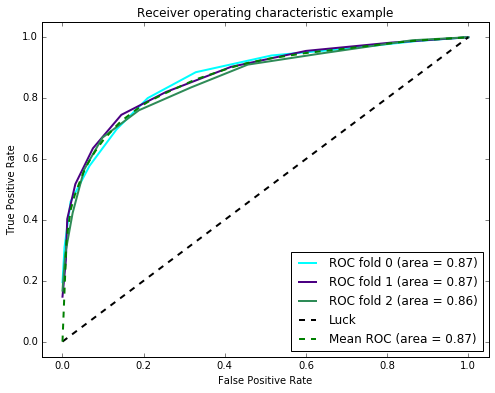




[[ 0.2  0.8]
 [ 0.8  0.2]
 [ 0.   1. ]
 [ 0.2  0.8]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.2  0.8]
 [ 0.6  0.4]
 [ 0.7  0.3]
 [ 0.2  0.8]]


('0.5', ' percent df')
balanced training data:  True
RandomForestClassifier


ValueError: Cannot take a larger sample than population when 'replace=False'

In [16]:
X = balanced_df.drop(['sequence','allergen'], axis=1)
y = balanced_df['allergen'].copy()
m = (0.5, 'balanced df')

classifiers = [rf]

tests = [(X, y, m)]

for percent_df in percent_dfs[4:]:
    X = percent_df.drop(['sequence','allergen'], axis=1)
    y = percent_df['allergen'].copy()
    m = str(df_ratio(percent_df)), ' percent df'
    tests.append((X, y, m))

evaluate_models(tests, classifiers, balance=[True, False])



('0.105545454545', 'sdf')
balanced training data:  True
Pipeline
f1 score:  0.662068965517


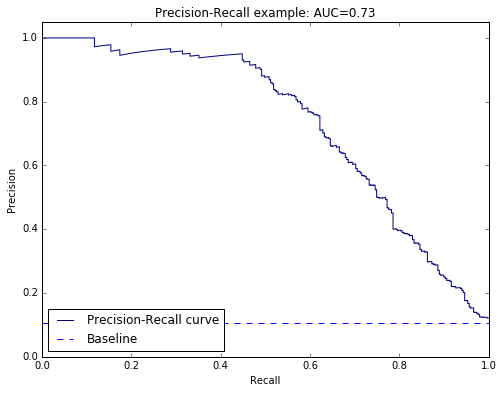

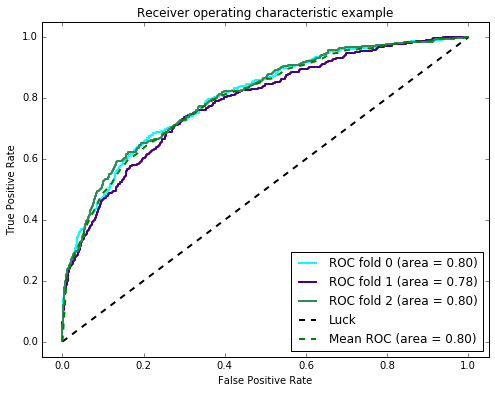




[[ 0.05084451  0.94915549]
 [ 0.80998598  0.19001402]
 [ 0.83392155  0.16607845]
 [ 0.77475532  0.22524468]
 [ 0.58215658  0.41784342]
 [ 0.80968514  0.19031486]
 [ 0.70690558  0.29309442]
 [ 0.65553973  0.34446027]
 [ 0.78206549  0.21793451]
 [ 0.86706846  0.13293154]]


('0.105545454545', 'sdf')
balanced training data:  False
Pipeline
f1 score:  0.0


/Users/Jake1/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


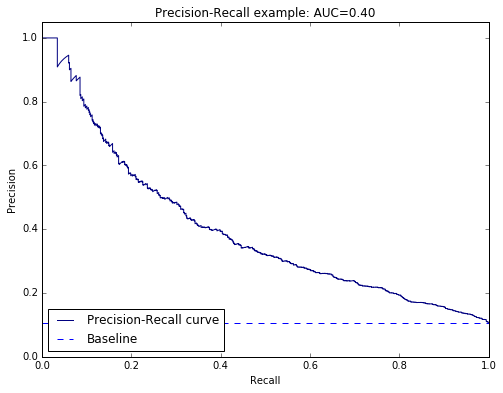

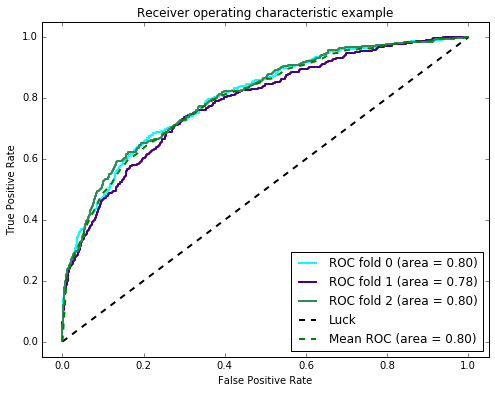




[[  9.99999991e-01   9.37197832e-09]
 [  9.99823462e-01   1.76538359e-04]
 [  9.99999998e-01   1.63608674e-09]
 [  1.00000000e+00   1.59521560e-10]
 [  9.99999963e-01   3.67366940e-08]
 [  9.99981757e-01   1.82430488e-05]
 [  9.99999907e-01   9.27126824e-08]
 [  9.99999502e-01   4.98155230e-07]
 [  9.99999392e-01   6.07873021e-07]
 [  9.99999984e-01   1.61935794e-08]]


('0.2', ' percent df')
balanced training data:  True
Pipeline
f1 score:  0.731448763251


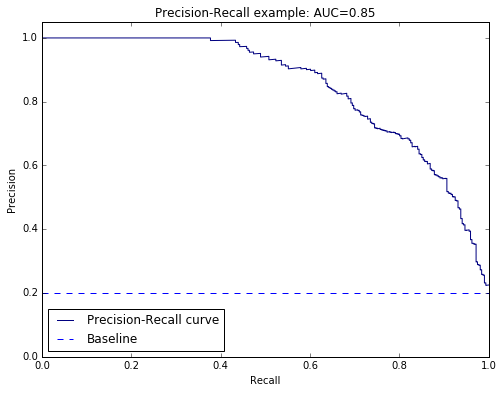

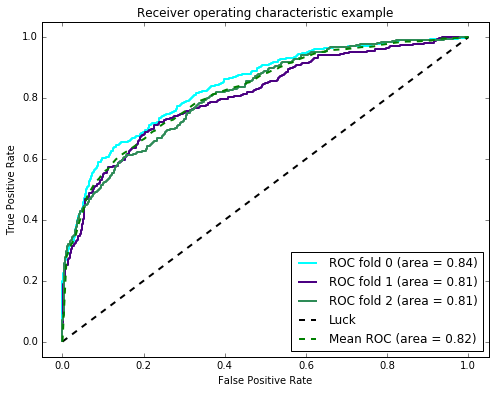




[[ 0.71608298  0.28391702]
 [ 0.72301479  0.27698521]
 [ 0.81033948  0.18966052]
 [ 0.59780658  0.40219342]
 [ 0.84715377  0.15284623]
 [ 0.63145325  0.36854675]
 [ 0.54001506  0.45998494]
 [ 0.82111007  0.17888993]
 [ 0.84978201  0.15021799]
 [ 0.76988202  0.23011798]]


('0.2', ' percent df')
balanced training data:  False
Pipeline
f1 score:  0.0797448165869


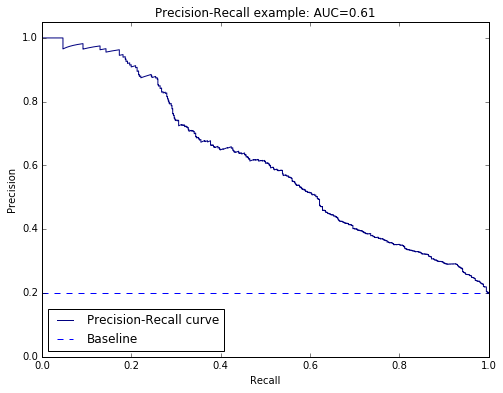

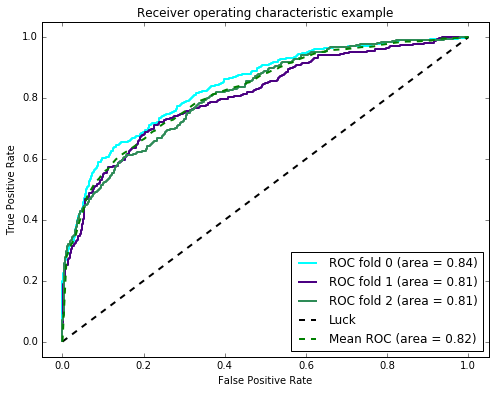




[[  9.99996084e-01   3.91614527e-06]
 [  9.99975679e-01   2.43212987e-05]
 [  9.99994638e-01   5.36230275e-06]
 [  9.99948738e-01   5.12622021e-05]
 [  9.99988708e-01   1.12917013e-05]
 [  9.98719551e-01   1.28044866e-03]
 [  9.99996824e-01   3.17563833e-06]
 [  9.99995295e-01   4.70476816e-06]
 [  9.99974380e-01   2.56196244e-05]
 [  9.99738006e-01   2.61993654e-04]]


('0.3', ' percent df')
balanced training data:  True
Pipeline
f1 score:  0.72


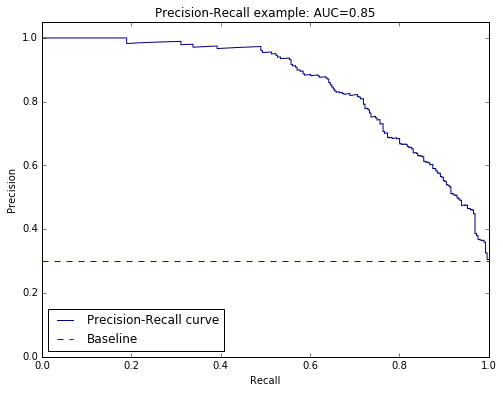

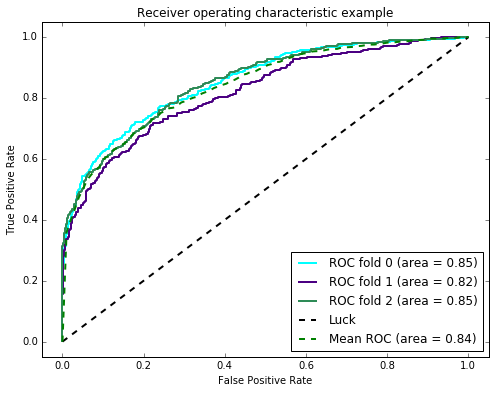




[[ 0.80269178  0.19730822]
 [ 0.04214579  0.95785421]
 [ 0.72952481  0.27047519]
 [ 0.57383332  0.42616668]
 [ 0.77944974  0.22055026]
 [ 0.818464    0.181536  ]
 [ 0.6753027   0.3246973 ]
 [ 0.87857337  0.12142663]
 [ 0.73038355  0.26961645]
 [ 0.67460407  0.32539593]]


('0.3', ' percent df')
balanced training data:  False
Pipeline
f1 score:  0.169440242057


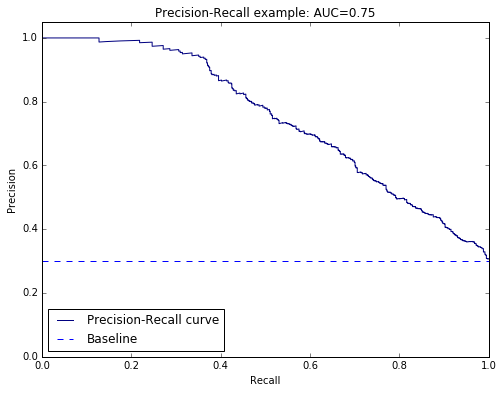

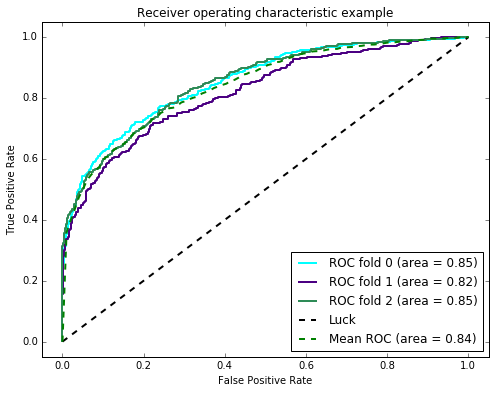




[[  9.99300848e-01   6.99151563e-04]
 [  9.97028414e-01   2.97158562e-03]
 [  9.99324940e-01   6.75060231e-04]
 [  9.97626397e-01   2.37360260e-03]
 [  9.99983470e-01   1.65298489e-05]
 [  9.98025244e-01   1.97475576e-03]
 [  9.99957687e-01   4.23128739e-05]
 [  2.66649347e-02   9.73335065e-01]
 [  8.83427867e-01   1.16572133e-01]
 [  9.99553997e-01   4.46002990e-04]]


('0.4', ' percent df')
balanced training data:  True
Pipeline
f1 score:  0.735849056604


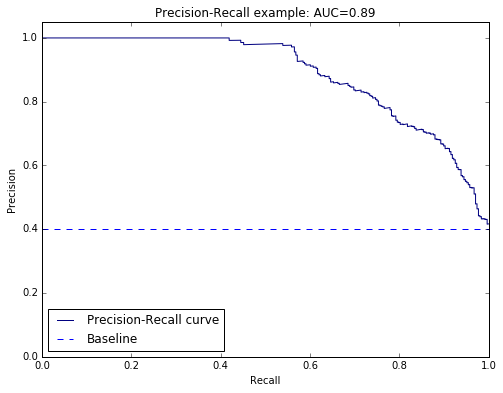

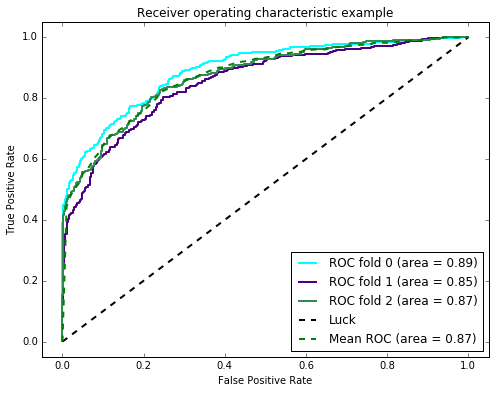




[[  7.87714341e-01   2.12285659e-01]
 [  3.91612299e-03   9.96083877e-01]
 [  6.58681345e-01   3.41318655e-01]
 [  6.13197408e-01   3.86802592e-01]
 [  6.91423741e-01   3.08576259e-01]
 [  7.17476217e-01   2.82523783e-01]
 [  1.35509766e-01   8.64490234e-01]
 [  9.20056721e-04   9.99079943e-01]
 [  6.88061615e-01   3.11938385e-01]
 [  5.59565661e-01   4.40434339e-01]]


('0.4', ' percent df')
balanced training data:  False
Pipeline
f1 score:  0.436129032258


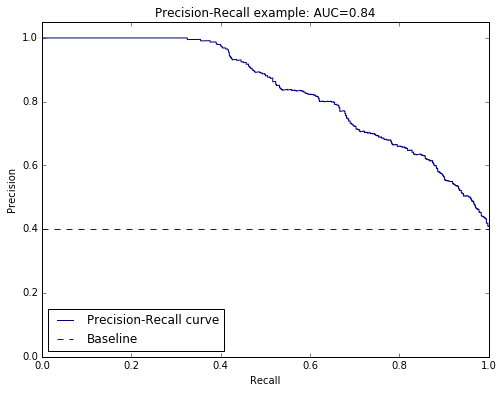

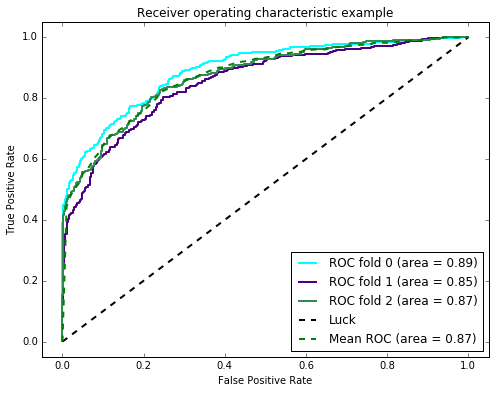




[[ 0.99111694  0.00888306]
 [ 0.92948385  0.07051615]
 [ 0.9785472   0.0214528 ]
 [ 0.44228699  0.55771301]
 [ 0.86587985  0.13412015]
 [ 0.95308034  0.04691966]
 [ 0.89692586  0.10307414]
 [ 0.92352883  0.07647117]
 [ 0.9914622   0.0085378 ]
 [ 0.12353361  0.87646639]]


('0.5', ' percent df')
balanced training data:  True
Pipeline
f1 score:  0.782273603083


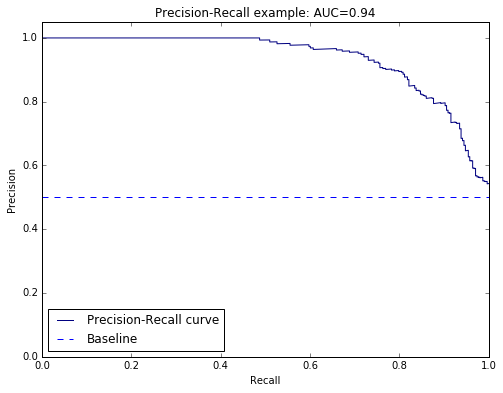

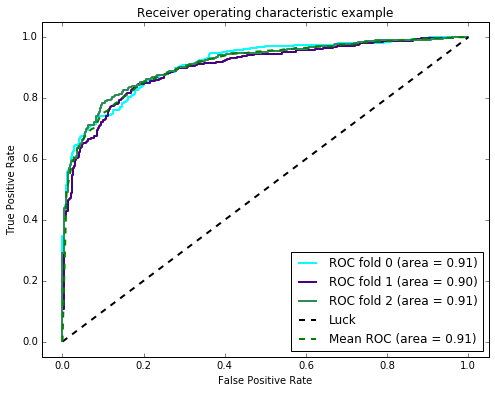




[[ 0.56131998  0.43868002]
 [ 0.4105863   0.5894137 ]
 [ 0.37670489  0.62329511]
 [ 0.00426205  0.99573795]
 [ 0.57335815  0.42664185]
 [ 0.27831178  0.72168822]
 [ 0.00289067  0.99710933]
 [ 0.68271059  0.31728941]
 [ 0.80785918  0.19214082]
 [ 0.58225492  0.41774508]]


('0.5', ' percent df')
balanced training data:  False
Pipeline
f1 score:  0.732451678535


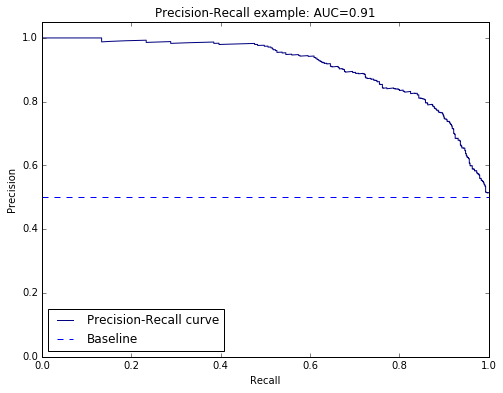

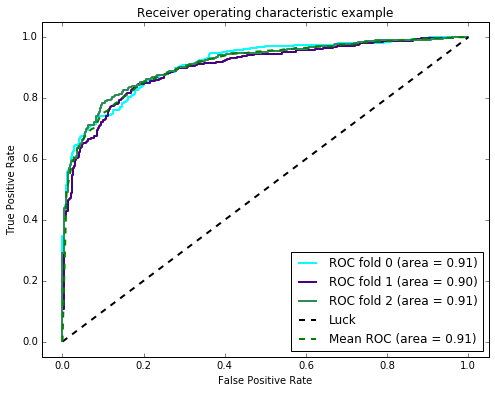




[[ 0.62978864  0.37021136]
 [ 0.75256446  0.24743554]
 [ 0.80992075  0.19007925]
 [ 0.70228255  0.29771745]
 [ 0.01939576  0.98060424]
 [ 0.73383933  0.26616067]
 [ 0.49238517  0.50761483]
 [ 0.37617309  0.62382691]
 [ 0.57413877  0.42586123]
 [ 0.62985077  0.37014923]]


In [13]:
X = sdf['sequence'].copy()
y = sdf['allergen'].copy()
m = (str(df_ratio(sdf)), 'sdf')
classifiers = [nb]
tests = [(X, y, m)]

for percent_df in percent_dfs[-4:]:
    X = percent_df['sequence'].copy()
    y = percent_df['allergen'].copy()
    m = str(df_ratio(percent_df)), ' percent df'
    tests.append((X, y, m))

evaluate_models(tests, classifiers, balance=[True, False])

## One class SVM

# forgot to scale data!

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
X_train = X_train[y_train == 1];
y_train = y_train[y_train == 1]

X_unlabeled = X_test[y_test == 0]
y_unlabeled = y_test[y_test == 0]

ss = StandardScaler(with_mean=False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_unlabeled = ss.transform(X_unlabeled)

clf = svm.OneClassSVM(nu=0.2, kernel="rbf", gamma=0.0009765625)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_train_scores = clf.decision_function(X_train)
y_pred_test = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
n_error_train = y_pred_train[y_pred_train == -1].size

y_pred_unlabeled = clf.predict(X_unlabeled)
y_unlabeled_scores = clf.decision_function(X_unlabeled)

y_pred_unlabeled_pos = y_pred_unlabeled[y_pred_unlabeled == 1]
y_pred_unlabeled_pos_prop = y_pred_unlabeled_pos.shape[0]*1.0/y_pred_unlabeled.shape[0]

print 'training size: ', X_train.shape[0]
# print 'test size', X_test.shape[0]
# print 'unlabeled size: ', X_unlabeled.shape[0]
print 'train error proportion: ', 1.0*n_error_train/X_train.shape[0]
print 'unlabeled positive proportion: ', y_pred_unlabeled_pos_prop

#doesn't do anything if both y_train and y_test are all positives
y_test = y_test.apply(lambda x: -1.0 if x == 0 else 1.0)
y_train = y_train.apply(lambda x: -1.0 if x == 0 else 1.0)

print classification_report(y_test, y_pred_test)
plot_precision_recall_curve(y_test, y_test_scores)

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1).copy()
y = sdf['allergen'].copy()
clf = svm.OneClassSVM(nu=0.10, kernel="rbf", gamma=0.1)
parameters = {'kernel':('rbf',), 'nu':[0.001, 0.01, 0.1, 0.2, 0.4, 0.6], 'gamma': [2**(-10), 2**(-5), 0.1, 1, 2, 8]}
gs_clf = GridSearchCV(clf, parameters, scoring='f1')
gs_clf.fit(X, y)
print gs_clf.best_score_, gs_clf.best_params_

## Semi-Supervised Learning

### label prop

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen'].copy()
unlabeled_set = y == 0
y_train = y.copy()
y_train[unlabeled_set] = -1
print X.shape, y_train.shape, unlabeled_set.shape, y_train[y_train == 1].shape

# lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
lp_model = label_propagation.LabelPropagation()
lp_model.fit(X, y_train)
predicted_labels = lp_model.predict_proba(X)
true_labels = y[unlabeled_set]

cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

### two-step

In [ ]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
nc = NearestCentroid(metric='cosine', shrink_threshold=0.2)
X = sdf.drop(['sequence','allergen'], axis=1).copy()
y = sdf['allergen'].copy()

nc.fit(X, y)
pred = nc.

## Ensemble

# Naive Bayes

In [108]:
clf = Pipeline([('vect', TfidfVectorizer(analyzer='char', ngram_range=(1,3))), ('nb', MultinomialNB())])
X = balanced_df['sequence']
y = balanced_df['allergen'].copy()

# vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
# X = vectorizer.fit_transform(X)

In [109]:
print cross_val_score(clf, X, y, cv=3, scoring='f1')

[ 0.73267327  0.69710807  0.74251497]
